In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import genpareto, poisson

In [ ]:
def simulate_hpp(T, rate):
    """
    Simulate a homogeneous poisson process with rate rate
    """
    Nt = poisson.rvs(T * rate)
    return np.sort(np.random.uniform(0, T, Nt))

In [ ]:
def simulate_ipp(T, rate, M):
    """
    Simulate a inhomogeneous poisson process with rate rate bounded by M
    """
    Tn = simulate_hpp(T, M)
    n = len(Tn)
    Un = np.random.uniform(0, M, n)
    return Tn[Un <= rate(Tn)]

In [ ]:
class ReserveModel():
    default_params = {
        'rate': lambda t: 1/5,  # inverse of the interarrival time between 2 hazards
        'rate_max': 1/5,  # maximum rate during a period
        # reserve
        'b': 0.05,  # percentage of NSC consumed during a year
        'B': 0.4,  # memory factor of previous damage
        'Rmax': 100,  # maximum NSC reserve
        'R0': 60,  # initial NSC reserve
        'p0': 5,  # fraction of NPP allocated when NPP is optimal
        # damage
        'lam': 10,  # average number of dry days per year
        'u': 2,  # GPD threshold
        'scale': 0.1,  # GPD scale
        'shape': -0.2,  # GPD shape
        'Ah': 0.6 / (0.4 + 1),  # normalizing constant
    }

    def __init__(self, params=None):
        if params is None:
          params = ReserveModel.default_params
        self.rate = ReserveModel.get_or_default('rate', params)
        self.rate_max = ReserveModel.get_or_default('rate_max', params)
        # reverse parameters
        self.b = ReserveModel.get_or_default('b', params)
        self.B = ReserveModel.get_or_default('B', params)
        self.Rmax = ReserveModel.get_or_default('Rmax', params)
        self.R0 = ReserveModel.get_or_default('R0', params)
        self.p0 = ReserveModel.get_or_default('p0', params)
        self.Ah = ReserveModel.get_or_default('Ah', params)
        # damage parameters
        self.lam = ReserveModel.get_or_default('lam', params)
        self.u = ReserveModel.get_or_default('u', params)
        self.scale = ReserveModel.get_or_default('scale', params)
        self.shape = ReserveModel.get_or_default('shape', params)
        self.Ah = ReserveModel.get_or_default('Ah', params)

    @classmethod
    def get_or_default(cls, p, params):
        return params[p] if p in params else cls.default_params[p]

    def evaluate_S(self):
        """
        Evaluate damage with current model parameters
        """
        M = 1 if self.lam <= 0 else poisson.rvs(self.lam)
        X = genpareto.rvs(c=self.shape, loc=self.u, scale=self.scale, size=M)
        return self.Ah * np.sum(X)

    def evaluate_R(self, last_R, S, last_S):
        """
        Evaluate reserve with current model parameters
        """
        p = self.p0 - self.B * last_S
        R = (1 - self.b) * last_R + p - S
        return min(R, self.Rmax)

    def run_simulation(self, T=100):
        """
        Run a simulation and return reserve and damage history as dict
        """
        hazard_years = np.unique(np.round(simulate_ipp(T, self.rate, self.rate_max)))
        if len(hazard_years) == 0:
          hazard_years = np.array([-1])
        next_hazard_idx = 0
        max_hazard_idx = len(hazard_years) - 1

        last_S = 0.
        last_R = self.R0
        R_history = np.zeros(T)
        S_history = np.zeros(T)

        for t in range(T):
            # Damage simulation
            if t == hazard_years[next_hazard_idx]:
              St = self.evaluate_S()
              next_hazard_idx = min(next_hazard_idx + 1, max_hazard_idx)
            else:
              St = 0.
            S_history[t] = St

            # Reserve simulation
            Rt = max(self.evaluate_R(last_R, St, last_S), 0.)
            R_history[t] = Rt
            if Rt <= 0.:
              break

            last_S = St
            last_R = Rt

        return {'R_history': R_history, 'S_history': S_history}

    def run_simulations(self, T=100, n_sim=int(1e4)):
        """
        Run n_sim simulation and return reserve and damage history as DataFrame
        """
        return pd.DataFrame([self.run_simulation(T) for _ in range(n_sim)])

    def run_monte_carlo_simulations(self, params, T=100, n_sim=int(1e4)):
        """
        Monte Carlo simulations for testing influence of params
        """
        mc_sim_stats = [None] * n_sim
        saved_params = self.rate, self.lam, self.u, self.scale, self.shape

        for i in range(n_sim):
          period = np.random.uniform(params['mc_period_min'], params['mc_period_max'])
          rate = lambda t: 1 / period
          lam = np.random.uniform(params['mc_lam_min'], params['mc_lam_max'])
          u = np.random.uniform(params['mc_u_min'], params['mc_u_max'])
          scale = np.random.uniform(params['mc_scale_min'], params['mc_scale_max'])
          shape = np.random.uniform(params['mc_shape_min'], params['mc_shape_max'])

          self.rate, self.lam, self.u, self.scale, self.shape = rate, lam, u, scale, shape
          sim = self.run_simulation(T)

          positive_years = sim['R_history'][sim['R_history'] > 0]
          R_mean = np.mean(positive_years) if len(positive_years) else 0
          empty_years = np.where(sim['R_history'] == 0)[0]
          ruin_time = empty_years[0] if len(empty_years) else T

          mc_sim_stats[i] = {
              'lambda': lam,
              'scale': scale,
              'shape': shape,
              'u': u,
              'period': period,
              'ruin_time': ruin_time,
              'R_mean': R_mean
          }

        self.rate, self.lam, self.u, self.scale, self.shape = saved_params
        return pd.DataFrame(mc_sim_stats)

In [ ]:
def get_simulation_stats(simulations):
    """
    Compute reverse mean (before ruin)
    Return q5, q50, q95 and ruin simulation
    """
    simulations['R_mean'] = simulations['R_history'].apply(lambda r: np.mean(r[r > 0]))
    simulations = simulations.sort_values(by=['R_mean'])

    sim_stats = {
        'all': simulations,
        'ruin': simulations.iloc[3],
        'q5': simulations.iloc[(int(0.05 * n_sim))],
        'q50': simulations.iloc[(int(0.5 * n_sim))],
        'q95': simulations.iloc[(int(0.95 * n_sim))],
    }
    return sim_stats

In [ ]:
def plot_model_behaviour(model_name, sim_stats):
    """
    Plot reserve history for q5, q50, q95 and ruin simulation
    plot damage history for q50 and ruin simulation
    """
    sim_ruin = sim_stats['ruin']
    sim_q5 = sim_stats['q5']
    sim_q50 = sim_stats['q50']
    sim_q95 = sim_stats['q95']
    T = len(sim_ruin['R_history'])

    fig, axs = plt.subplots(2, 1, figsize=(7, 10))
    plt.subplots_adjust(hspace=0.4)
    x_axis = np.arange(1, T+1)

    empty_reserve_years = np.where(sim_ruin['R_history'] == 0)[0]
    ruin_time = empty_reserve_years[0] if len(empty_reserve_years) else T
    is_before_ruin = sim_ruin['R_history'] > 0
    is_before_ruin[ruin_time] = True

    # Plot damages S(t)
    s_before_ruin = sim_ruin['S_history'][is_before_ruin]

    axs[0].set_title(model_name)
    axs[0].plot(x_axis, sim_q50['S_history'], color='black', label=f'q50')
    axs[0].plot(s_before_ruin, color='red', linewidth=3, label=f'Ruin')
    axs[0].axvline(x=ruin_time, color='red', linestyle='--')

    axs[0].set_xlabel('Time')
    axs[0].set_xlim(1, 100)
    axs[0].set_ylabel('Damages S')
    axs[0].legend(loc='upper left', ncol=2)
    axs[0].grid(True)

    # Plot reserve R(t)
    sims = [sim_ruin, sim_q5, sim_q50, sim_q95]
    sim_labels = ['Ruin', 'q5', 'q50' ,'q95']
    colors = ['red', 'orange', 'black', 'blue']
    widths = [3, 1, 1, 1]

    for sim, sim_label, color, width in zip(sims, sim_labels, colors, widths):
        axs[1].plot(x_axis, sim['R_history'], color=color, linewidth=width, label=sim_label)
        axs[1].axhline(y=sim['R_mean'], color=color, linestyle='--')
    axs[1].axvline(x=ruin_time, color='red', linestyle='--')

    axs[1].set_xlabel('Time')
    axs[1].set_xlim(1, 100)
    axs[1].set_ylabel('Reserve R')
    axs[1].legend(loc='upper left', ncol=4)
    axs[1].grid(False)

    plt.savefig(f'{model_name}.pdf')
    plt.show()

In [ ]:
# Model definition
np.random.seed(42)
n_sim = int(1e4)
T = 100
B = 0
Ah = 0.6 / (B + 1)
rate_ipp = lambda t: 1 / np.ceil(6 - np.exp(t/60))
rate_ipp_max = rate_ipp(T)

models = {
    'isohydric': ReserveModel({'B': B, 'Ah': Ah}),
    'anisohydric': ReserveModel(),
    'inhomogeneous': ReserveModel({'B': B, 'Ah': Ah, 'rate': rate_ipp, 'rate_max': rate_ipp_max}),
}

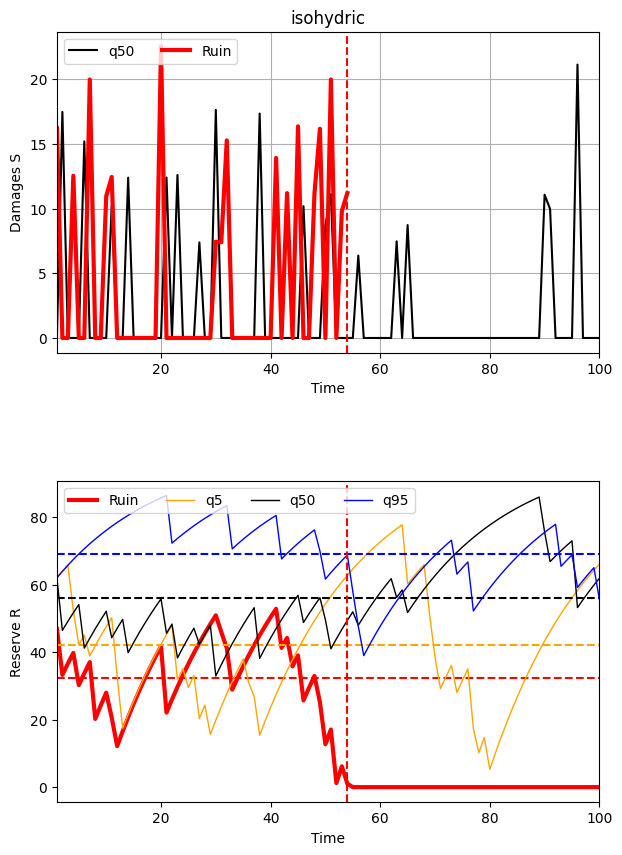

In [ ]:
# Isohydric simulation
simulations_iso = models['isohydric'].run_simulations(T, n_sim)
sim_iso_stats = get_simulation_stats(simulations_iso)
plot_model_behaviour('isohydric', sim_iso_stats)

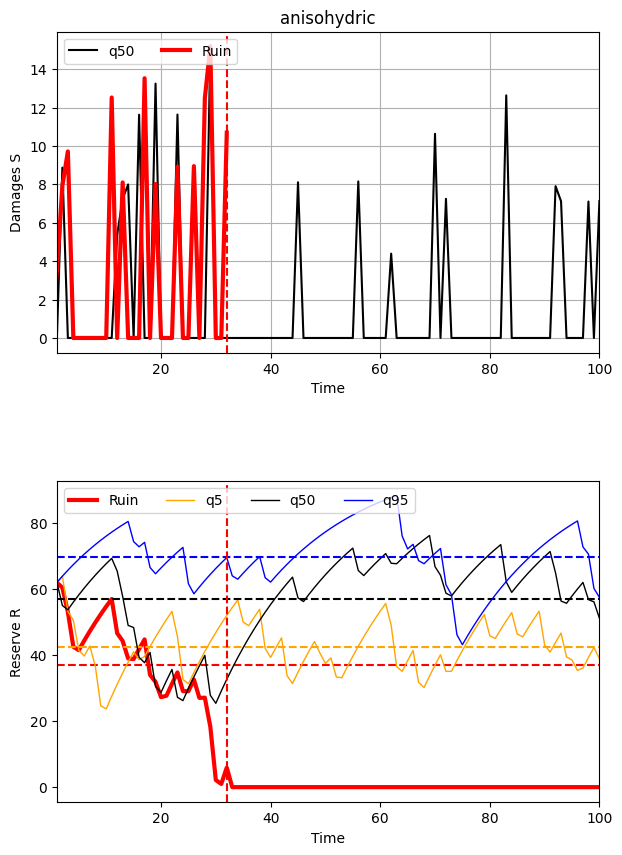

In [ ]:
# Anisohydric simulation
simulations_ani = models['anisohydric'].run_simulations(T, n_sim)
sim_ani_stats = get_simulation_stats(simulations_ani)
plot_model_behaviour('anisohydric', sim_ani_stats)

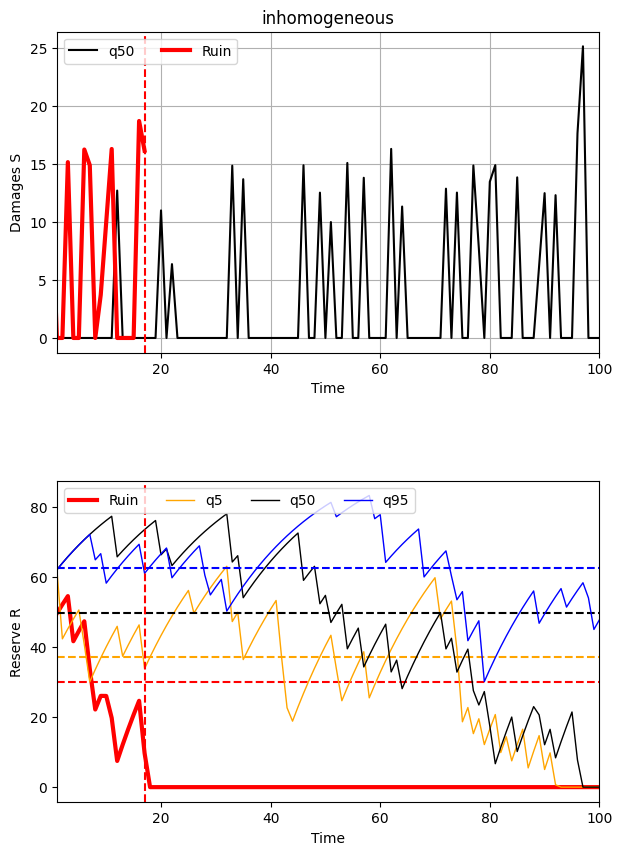

In [ ]:
# Inhomogeneous simulation
simulations_ipp = models['inhomogeneous'].run_simulations(T, n_sim)
sim_ipp_stats = get_simulation_stats(simulations_ipp)
plot_model_behaviour('inhomogeneous', sim_ipp_stats)

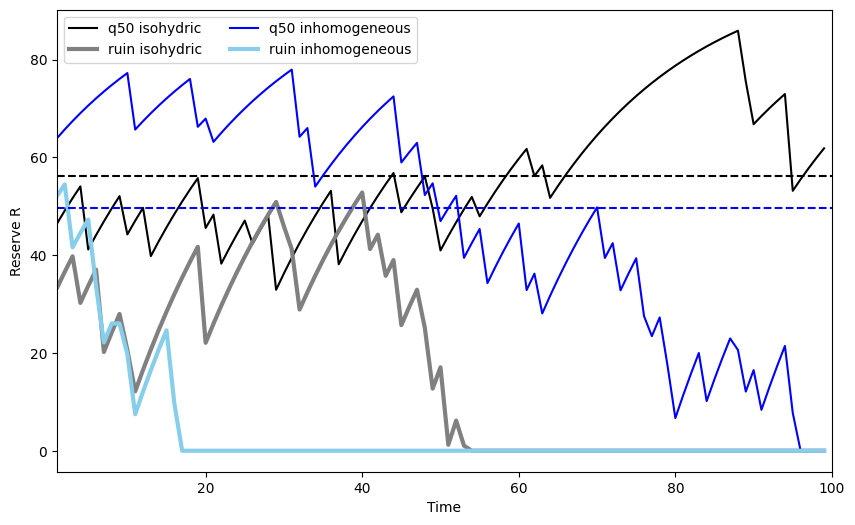

In [ ]:
# Comparison between isohydric and inhomogeneous
fig, ax = plt.subplots(figsize=(10, 6))

x_axis = np.arange(T)
ax.plot(x_axis, sim_iso_stats['q50']['R_history'], color='black', label='q50 isohydric')
ax.plot(x_axis, sim_iso_stats['ruin']['R_history'], color='grey', linewidth=3, label='ruin isohydric')
ax.axhline(y=sim_iso_stats['q50']['R_mean'], color='black', linestyle='--')

ax.plot(x_axis, sim_ipp_stats['q50']['R_history'], color='blue', label='q50 inhomogeneous')
ax.plot(x_axis, sim_ipp_stats['ruin']['R_history'], color='skyblue', linewidth=3, label='ruin inhomogeneous')
ax.axhline(y=sim_ipp_stats['q50']['R_mean'], color='blue', linestyle='--')

ax.set_ylabel('Reserve R')
ax.set_xlabel('Time')
ax.set_xlim(1, 100)
ax.legend(loc='upper left', ncol=2)
ax.grid(False)

plt.savefig('iso_ipp_comparison.pdf')
plt.show()

In [ ]:
# Monte Carlo simulations for parameters influence
mc_params = {
    'mc_period_min': 2,
    'mc_period_max': 15,
    'mc_lam_min': 2,
    'mc_lam_max': 30,
    'mc_u_min': 1,
    'mc_u_max': 5,
    'mc_scale_min': 0.08,
    'mc_scale_max': 0.2,
    'mc_shape_min': -0.45,
    'mc_shape_max': -0.2,
}
mc_n_sim = int(1e5)
mc_simulations = models['isohydric'].run_monte_carlo_simulations(mc_params, T, mc_n_sim)

In [ ]:
mc_simulations.loc[:, 'period'] = np.round(mc_simulations.loc[:, 'period'])
mc_simulations.loc[:, 'lambda'] =  np.round(mc_simulations.loc[:, 'lambda'] / 2) * 2
mc_simulations.loc[:, 'scale'] =  np.round(mc_simulations.loc[:, 'scale'] * 40) / 40
mc_simulations.loc[:, 'shape'] =  np.round(mc_simulations.loc[:, 'shape'] * 40) / 40
mc_simulations.loc[:, 'u'] =  np.round(mc_simulations.loc[:, 'u'] * 4) / 4

In [ ]:
# !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [ ]:
plt.rcParams['text.usetex'] = True

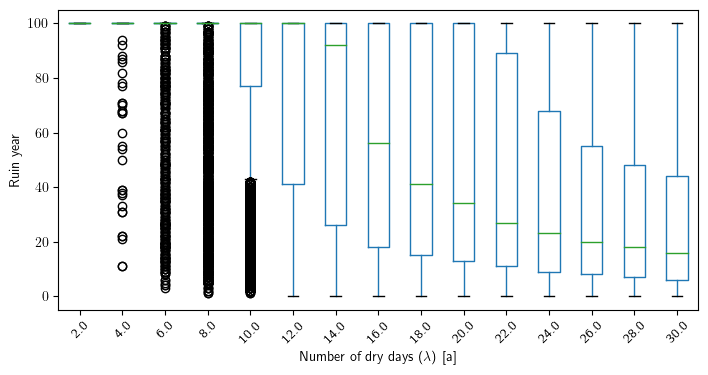

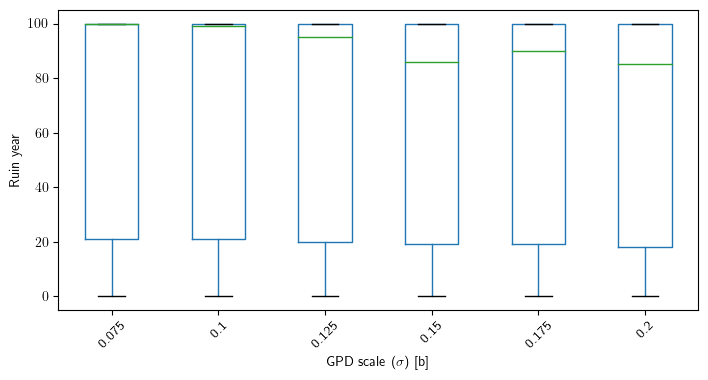

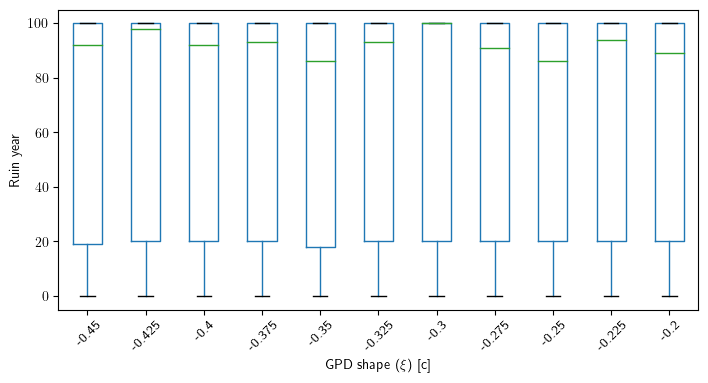

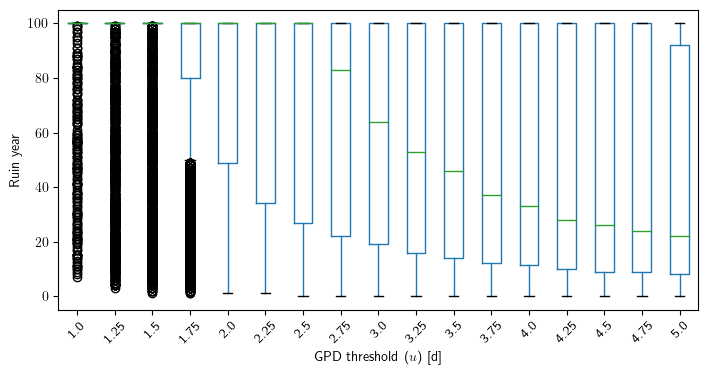

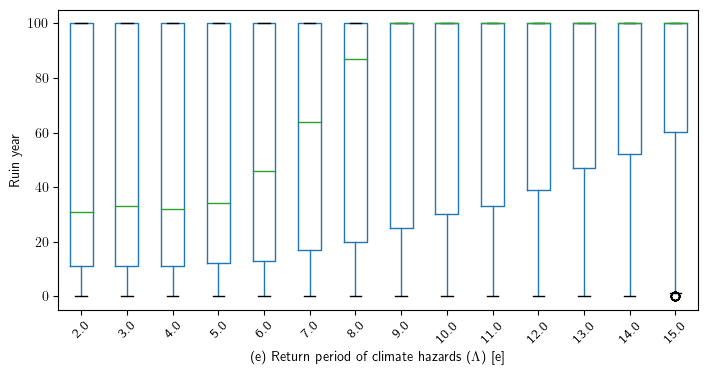

In [ ]:
# Boxplots describing parameters influence
param_desc = [
    ['lambda', r'Number of dry days ($\lambda$) [a]'],
    ['scale', r' GPD scale ($\sigma$) [b]'],
    ['shape', r' GPD shape ($\xi$) [c]'],
    ['u', r' GPD threshold ($u$) [d]'],
    ['period', r'(e) Return period of climate hazards ($\Lambda$) [e]']
]

for param, desc in param_desc:
    boxplot = mc_simulations.boxplot(
        column=['ruin_time'], by=[param], grid=False, rot=45,
        fontsize=10, return_type='dict', figsize=(8,4))
    plt.title('')
    plt.suptitle('')
    plt.xlabel(desc)
    plt.ylabel('Ruin year')
    plt.savefig(f'ruin_year_{param}.pdf')